# Applying ICA / NMF to AOCS Ovarian Cancer gene expression

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, FastICA, PCA
import statsmodels.formula.api as sm

In [10]:
#import ipywidgets
#import ipysheet
import qgrid

In [11]:
def example_V(n_genes=100):
    # Generate example expression matrix, useful in tests
    np.random.seed(0)
    time = np.linspace(0, 8, n_genes)

    s1 = np.sin(time) + 1.1  # Signal 1 : sinusoidal signal
    s2 = np.sign(np.sin(3 * time)) + 1.1  # Signal 2: square signal
    s3 = np.sin(2 * np.pi * time) + 1.1  # Signal 3: saw tooth signal
    s4 = np.cos(0.5 * np.pi * time) + 1.1  # Signal 4: cosine
    s5 = np.sin(0.2 * np.pi * time) + 1.1  # Signal 5: higher freq sine

    W = np.c_[s1, s2, s3, s4, s5]
    W += 0.1 * np.random.normal(size=W.shape)  # Add noise

    W /= W.std(axis=0)  # Standardize data
    # Mix data
    H = np.array([[1, 1, 1, 1, 1], [0.5, 0/6, 1, 1.2, 1], [1.5, 1, 2, 1, 1.1],
                 [1, 0.4, 1, 1.1, 0.1], [1, 0.2, 0.8, 1, 1.5]])  # Mixing matrix
    V = np.dot(W, H.T)  # Generate observations
    return V

def test_example_V():
    ngenes = 10
    eg_V = example_V(ngenes)
    print(eg_V.shape)
    print(eg_V)
    assert eg_V.shape == (10, 5)
    assert np.all(eg_V >= 0)
test_example_V()

(10, 5)
[[ 9.49829011  7.9887533  12.38914531  7.54443541  9.00526306]
 [ 9.31289633  6.05630711 11.44860862  6.09348971  8.40364348]
 [ 6.37978511  4.70311611  8.40012266  3.82744033  7.45494186]
 [ 8.39341203  5.04783379 10.09289634  4.65810548  7.72993879]
 [ 7.16218499  7.13682892  9.0400201   4.78370984  8.1530818 ]
 [ 9.08477442  7.36525148 11.46343396  6.11719243  7.89864277]
 [ 5.08133288  4.82677779  8.27545365  4.03035689  4.95313707]
 [ 5.72945428  4.78751277  9.88611114  5.15853024  5.11136278]
 [ 8.89296018  5.97450333 12.51477424  7.73541689  6.79364127]
 [ 7.27943466  6.37738398 10.5233532   7.3930868   7.02470641]]


In [12]:
# Make wrapper classes for FastICA and NMF, so we can interface to them identically
class ICA_Factorizer(FastICA):
    def __init__(self, n_components=None, max_iter=200, 
                 random_state=42, fun='logcosh'):
        FastICA.__init__(self, n_components=n_components, max_iter=max_iter,
                        random_state=random_state, fun=fun)
        self.V = None
        self.W = None
        self.H = None
        self.recovered_V = None
        
    def fit(self, V):
        self.V = V
        self.W = self.fit_transform(V)
        
    def get_W(self):
        assert self.V is not None
        if self.W is None:
            self.W = self.fit_transform(self.V)
        return self.W
    
    def get_H(self):
        assert self.V is not None
        if self.H is None:
            self.H = self.mixing_.T
        return self.H
    
    def get_recovered_V(self):
        assert self.V is not None
        if self.recovered_V is None:
            W = self.get_W()
            H = self.get_H()
            mean = self.mean_
            self.recovered_V = np.dot(W, H) + mean
            #print(self.recovered_V)
        return self.recovered_V

def test_Factorizer(facto, atol):
    print(facto)
    V = example_V(10)
    nc = V.shape[1]
    
    facto.fit(V)
    
    W = facto.get_W()
    assert W.shape == (V.shape[0], nc)
    
    H = facto.get_H()
    assert H.shape == (nc, V.shape[1])
    
    V2 = facto.get_recovered_V()
    assert np.allclose(V, V2, atol=atol)
        
    print("test_Factorizer (%s) passed" % type(facto).__name__)
    
test_Factorizer(ICA_Factorizer(n_components=5), atol=0.0001) 

ICA_Factorizer(fun='logcosh', max_iter=200, n_components=5, random_state=42)
test_Factorizer (ICA_Factorizer) passed


In [13]:
class NMF_Factorizer(NMF):
    def __init__(self, n_components=None, max_iter=200, random_state=42):
        NMF.__init__(self, n_components=n_components, max_iter=max_iter, 
                     random_state=random_state)
        self.V = None
        self.W = None
        self.H = None
        self.recovered_V = None
        
    def fit(self, V):
        self.V = V
        self.W = self.fit_transform(V)
        
    def get_W(self):
        assert self.V is not None
        if self.W is None:
            self.W = self.fit_transform(self.V)
        return self.W
    
    def get_H(self):
        assert self.V is not None
        if self.H is None:
            self.H = self.components_
        return self.H
    
    def get_recovered_V(self):
        assert self.V is not None
        if self.recovered_V is None:
            W = self.get_W()
            H = self.get_H()
            self.recovered_V = np.dot(W, H)
            #print(self.recovered_V)
        return self.recovered_V

test_Factorizer(NMF_Factorizer(n_components=5), atol=0.2) 

NMF_Factorizer(max_iter=200, n_components=5, random_state=42)
test_Factorizer (NMF_Factorizer) passed


### Matrix plotting utility

In [14]:
def l2_norm_diff(m1, m2):
    return np.mean(np.sqrt((m1 - m2)**2))

def test_l2_norm_diff():
    V = example_V(10)
    rms = l2_norm_diff(V, V+0.5)
    assert np.isclose(rms,0.5)
    
test_l2_norm_diff() 

v.shape (10, 5)
H.shape (2, 5)


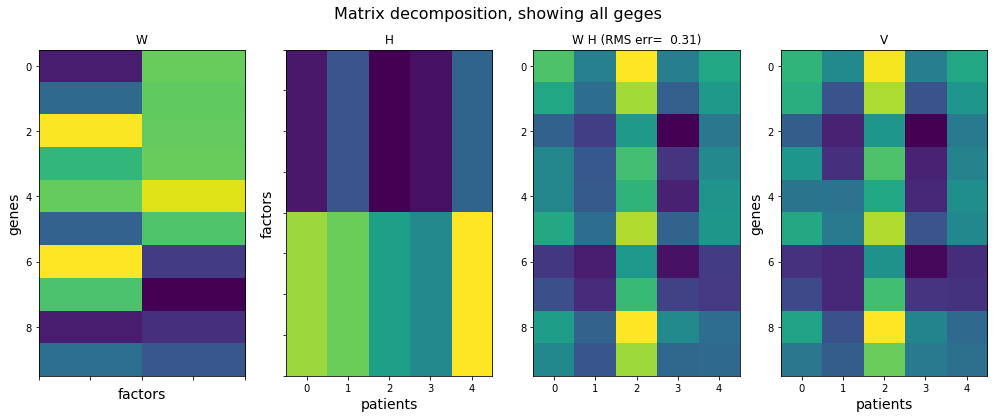

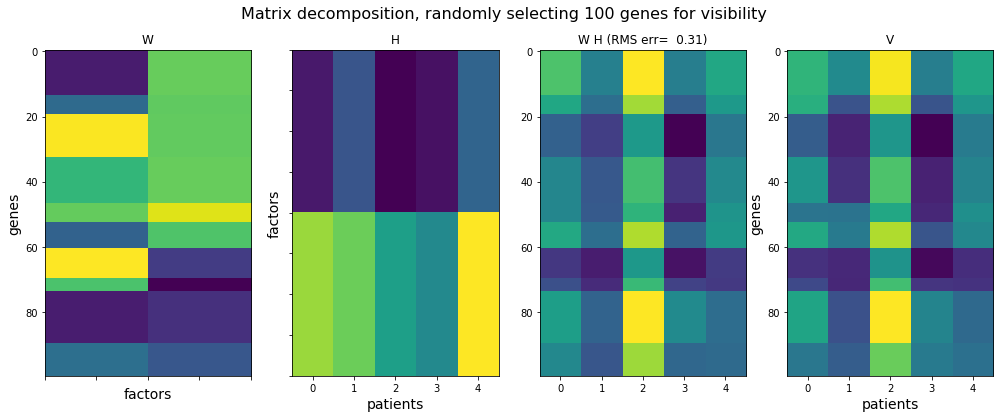

In [15]:
def show_W_H_WH_V(W, H, V, rec_V, n_genes_to_pick=None):
    """ Show factorization matrices in visually pleasing form"""
    
    if n_genes_to_pick is None:
        gene_ixs = range(V.shape[0])
        title = "Matrix decomposition, showing all geges"
    else:
        gene_ixs = sorted(np.random.randint(0, V.shape[0], n_genes_to_pick))
        title = "Matrix decomposition, randomly selecting %d genes for visibility" % n_genes_to_pick
    fig, axs = plt.subplots(1,4, figsize=(17,6))
    fig.suptitle(title, size=16)
    axs[0].imshow(W[gene_ixs,:], aspect='auto')
    axs[0].set_title('W')
    axs[0].set_ylabel('genes', size=14)
    axs[0].set_xlabel('factors', size=14)
    
    axs[0].set_xticklabels('')
    
    axs[1].imshow(H, aspect='auto')
    axs[1].set_title('H')
    axs[1].set_ylabel('factors', size=14)
    axs[1].set_xlabel('patients', size=14)
    axs[1].set_yticklabels('')
    
    rms_err = l2_norm_diff(rec_V, V)
    axs[2].imshow(rec_V[gene_ixs,:], aspect='auto')
    axs[2].set_title('W H (RMS err=%6.2f)' % rms_err)
   
    
    axs[3].imshow(V[gene_ixs,:], aspect='auto')
    axs[3].set_title('V')
    axs[3].set_ylabel('genes', size=14)
    axs[3].set_xlabel('patients', size=14)

    plt.show()

def test_show_W_H_WH_V():
    
    V = example_V(10)
    print("v.shape", V.shape)
    facto = ICA_Factorizer(n_components=2)
    facto.fit(V)
    W = facto.get_W()
    H = facto.get_H()
    print("H.shape", H.shape)
    
    show_W_H_WH_V(W,H, V, facto.get_recovered_V())
    show_W_H_WH_V(W,H,V, facto.get_recovered_V(), 100)
test_show_W_H_WH_V()    


## Read and explore the expression matrix

In [16]:
# Read in AOCS spreadsheet
expression_df = pd.read_csv('AOCS_TPM_VST.csv')

assert len(expression_df) == 57914
assert len(expression_df.columns == 80 + 1)
assert expression_df.columns[0] == 'GeneENSG'
assert expression_df.columns[-1] == 'AOCS_171'

expression_matrix = np.asarray(expression_df.iloc[:,1:])

print(expression_matrix.shape[0], "genes")
print(expression_matrix.shape[1], "patients")

57914 genes
80 patients


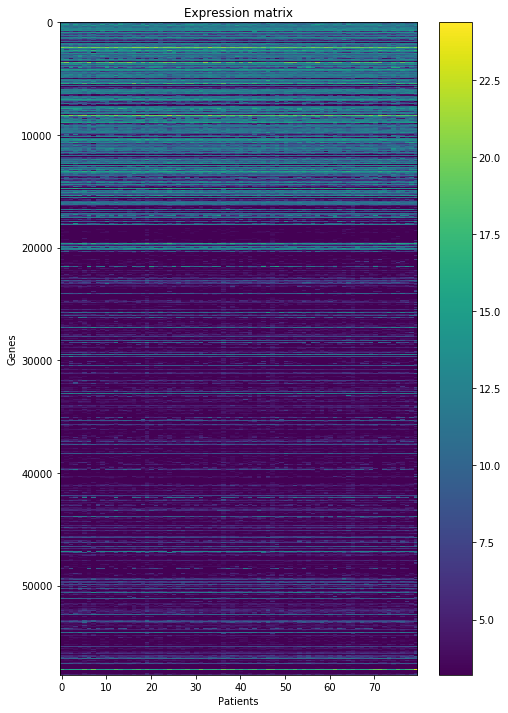

In [17]:
plt.figure(figsize=(8, 12))
plt.imshow(expression_matrix, aspect='auto')
plt.colorbar()
plt.xlabel(("Patients"))
plt.ylabel(("Genes"))
plt.title("Expression matrix")
plt.show()

## Note prior normalisation of the expression array
Normalisation was applied by Ailith's script, using the method of a varaince stabalising transform.  See below, all patients have a minimum of aproximately 3.5, maximum approaximately 23.

In [18]:
expression_df.describe()

,AOCS_001,AOCS_004,AOCS_005,AOCS_034,AOCS_055,AOCS_056,AOCS_057,AOCS_058,AOCS_059,AOCS_060,...,AOCS_161,AOCS_162,AOCS_163,AOCS_164,AOCS_165,AOCS_166,AOCS_168,AOCS_169,AOCS_170,AOCS_171
count,57914.000000,57914.000000,57914.000000,57914.000000,57914.000000,57914.000000,57914.000000,57914.000000,57914.000000,57914.000000,...,57914.000000,57914.000000,57914.000000,57914.000000,57914.000000,57914.000000,57914.000000,57914.000000,57914.000000,57914.000000
mean,5.926101,5.938991,6.007152,5.952262,5.956755,6.073466,6.007817,5.818777,5.891482,5.980886,...,5.995957,5.865829,6.002902,5.884181,5.993003,6.000075,6.040593,6.021391,5.979997,6.200779
std,3.553952,3.574188,3.497501,3.591652,3.567142,3.451150,3.501080,3.640556,3.563826,3.524815,...,3.464774,3.641409,3.457987,3.533381,3.454991,3.473705,3.444295,3.456582,3.511552,3.436512
min,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,...,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976
25%,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,...,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976
50%,4.044184,4.079719,4.208497,4.063436,4.122186,4.408961,4.208462,3.207976,4.011039,4.159508,...,4.260048,3.861947,4.275016,4.056760,4.262733,4.252683,4.349923,4.288524,4.175397,5.008441
75%,8.085794,7.952447,8.259084,8.166769,8.199995,8.367150,8.293475,8.151407,8.021214,8.095177,...,8.199894,7.981563,8.268311,7.897374,8.186377,8.467566,8.338740,8.180828,8.211930,8.511383
max,23.938739,23.191228,23.918881,22.272548,24.011974,22.908584,23.120995,23.144337,23.631234,23.228671,...,22.297948,23.069532,22.450623,22.716559,23.112822,22.526332,23.290668,22.700932,23.418327,24.166216


## Plot distributions of expression data
... for a quick visual check.

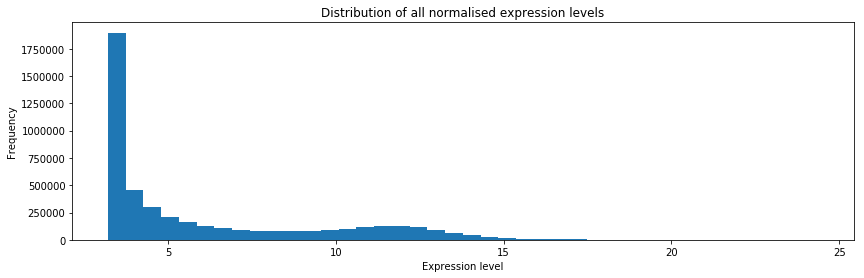

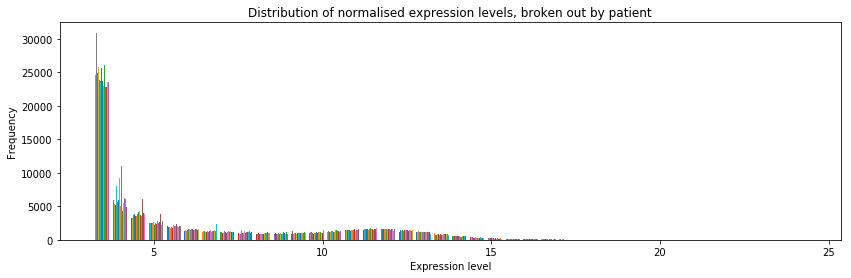

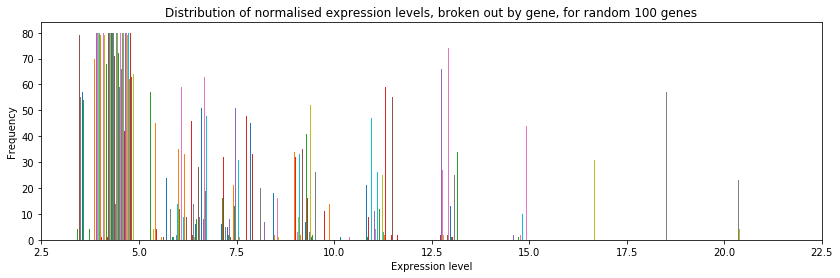

In [19]:
def show_expression_distributions(V):
    def labeled_figure():
        plt.figure(figsize=(14,4))
        plt.xlabel('Expression level')
        plt.ylabel('Frequency')
        
    if True:
        labeled_figure()
        _ = plt.hist(V.ravel(), bins=40)
        plt.title("Distribution of all normalised expression levels")
        plt.show()
    
    if True:
        labeled_figure()
        _ = plt.hist(V, bins=40)
        plt.title("Distribution of normalised expression levels, broken out by patient")
        plt.show()
        
    if True:
        labeled_figure()
        n_genes_to_pick = 100
        random_gene_ixs = sorted(np.random.randint(0, V.shape[0], n_genes_to_pick))
        _ = plt.hist(V[random_gene_ixs,:].T, bins=10)
        plt.title("Distribution of normalised expression levels, broken out by gene, for random %d genes" %
                  n_genes_to_pick)
        plt.show()
    
show_expression_distributions(expression_matrix)


## Read the patient metadata
In particular we are interested in treatment "Resposnse", which we scraped from the Patch paper (code at end of notebool).

In [20]:
# Read metadata (which we scraped from the Patch etal paper!)
metadata_df = pd.read_csv('AOCS_metadata.csv', index_col='AOCS_ID')
assert metadata_df.columns[0] == "Age"
assert metadata_df.columns[1] == "Response"
# Make sure the IDs match-up between the two dataframes
assert (all(metadata_df.index == expression_df.columns[1:]))
metadata_df['Response'].value_counts()

Resistant     37
Sensitive     31
Refractory    12
Name: Response, dtype: int64

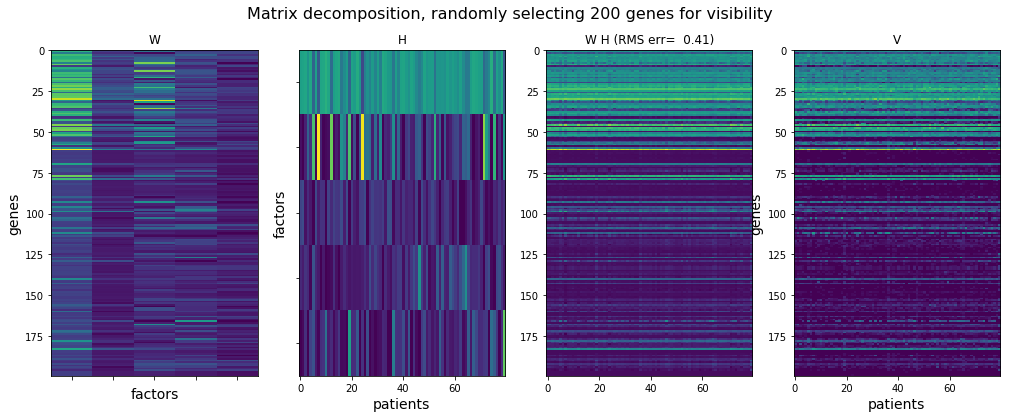

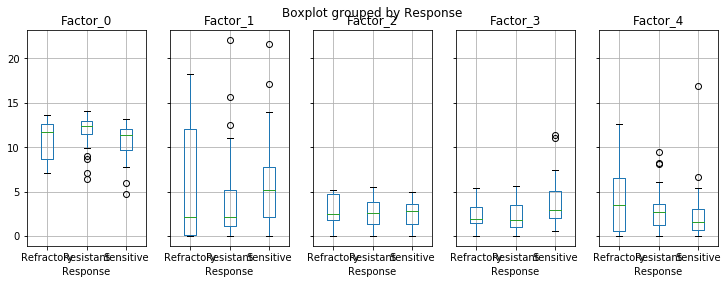

{'best_rsq': 0.12336416709911835,
 'best_factor': 3,
 'rms_err': 0.4144906061584977}

In [21]:
def fit_and_plot_model(V, met_df, facto, plot=True):
    # print("---------------------------------------------------------------------------")
    # print(facto)

    facto.fit(V)
    W = facto.get_W()
    H = facto.get_H()

    if plot:
        show_W_H_WH_V(W, H, V, facto.get_recovered_V(), n_genes_to_pick=200)
    
    plot_df = metadata_df.copy()
    
    factors = ['Factor_%d'%i for i in range(facto.n_components)]
    for i in range(len(factors)):
        plot_df[factors[i]] = H[i, :]
    
    if plot:
        plot_df.boxplot(column=factors, by='Response', fontsize=10, figsize=(12,4), layout=(1, facto.n_components))
        plt.show()    
    
    # Put together a dictionary or results
    results_dict = {}
    
    # Find factor which best explains response
    
    ols_results = [sm.ols(fact + '~ C(Response)', data=plot_df).fit() for fact in factors]
    rsqs = [res.rsquared for res in ols_results]
    results_dict['best_rsq'] = np.max(rsqs)
    results_dict['best_factor'] = np.argmax(rsqs)
    results_dict['rms_err'] = l2_norm_diff(V, facto.get_recovered_V())
    
    return results_dict

result = fit_and_plot_model(expression_matrix, metadata_df,     
                            NMF_Factorizer(n_components=5),
                            plot=True)
result

In [24]:
# Explore results for NMF and ICA, generating a list of dictionaries
results1 = None
if False:
    Factos = [ICA_Factorizer, NMF_Factorizer]
    results1 = []
    for nc in range(1,7):
        for random_state in [42, 345, 13]:
            for Facto in Factos:
                params = {'n_components':nc, 'random_state':random_state}
                
                facto = Facto(**params)
                params['which'] = type(facto).__name__
                print(params)
                res = fit_and_plot_model(expression_matrix, metadata_df, facto, plot=False)
                print(res)
                results1.append({**params, **res})


In [25]:
if results1:
    results1_df = pd.DataFrame(results1)
    qgrid.show_grid(results1_df)
    results1_df.to_csv('nmf_ica_results.csv')

In [28]:
# Explore FastICA with 5 components, for various parameterss

results2 = None
if False:
    results2 = []
    nc = 5
    for random_state in [0, 42, 345, 13, 564]:
        for max_iter in [200]:
            for fun in 'logcosh', 'exp', 'cube':
                params = {'n_components':nc, 'random_state':random_state,
                          'fun':fun, 'max_iter':max_iter}
                print(params)
                facto = ICA_Factorizer(**params)
                res = fit_and_plot_model(expression_matrix, metadata_df, facto, plot=False)
                print(res)
                results2.append({**params, **res})

In [29]:
if results2:
    results2_df = pd.DataFrame(results2)
    results2_df.to_csv('ica_fun_results.csv')
    qgrid.show_grid(results2_df)

## Exploring distribution of weights in W and H matrices

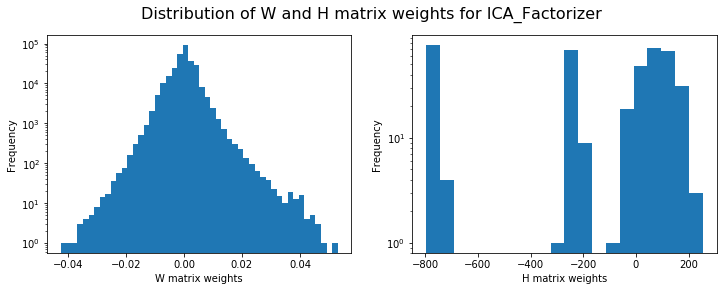

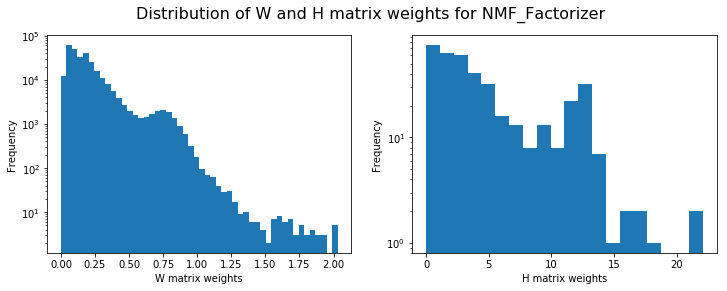

In [30]:
def plot_matrix_weight_distributions(facto):
    facto.fit(expression_matrix)
    W = facto.get_W()
    H = facto.get_H()

    plt.figure(figsize=(12, 4))
    plt.suptitle("Distribution of W and H matrix weights for %s" %type(facto).__name__, size=16)
    plt.subplot(1,2,1)
    plt.hist(W.ravel(), bins=50, log=True)
    plt.xlabel("W matrix weights")
    plt.ylabel("Frequency")
    plt.subplot(1,2,2)
    plt.hist(H.ravel(), bins=20, log=True)
    plt.ylabel("Frequency")
    plt.xlabel("H matrix weights")
    plt.show()
    
facto = ICA_Factorizer(n_components=5)
plot_matrix_weight_distributions(facto)

facto = NMF_Factorizer(n_components=5)
plot_matrix_weight_distributions(facto)




### Following is run-once code for recovering metadata from Patch et al paper...

## Conclusions
* Five components seems to be best for both ICA and NMF w.r.t Response correlation with Response. 
* ICA delivers sligntly better $R^2$ for correlation.  With 5 components $R^2$ = 0.145 and 0.363 for ICA and NMF respectively.
* RMS error improves with number of components, as expected, but only modestly -- 0.499 to 0.403 for 1 to 6 components.
* RMS error between W H and V is almost constant at 0.416 with 5 components, regardless of algorithm ICA / NMF choice or other hyper-parameters.
* NMF seems immune to random effects (random seeds).
* ICA shows modest random effects, in respect of the $R^2$ measure.
* ICA shows identical results for max_iter in range 100 - 5000; suggests the default 200 can safely be used.
* The optimised functional in ICA, among the options of logcosh, exp and cube have less effect than the random seed.   Some suggestion that the default logcosh is marginally optimal, exp is worst.
* NMF delivers W and H matrices such that W.H = V.  This is not quite the case for ICA, due to whitening.   For ICA we need W.H + mean = V.


  

In [31]:
# Extract age and response group from scraped text file
def extract_metadata_from_crazy_scraped_file(scrape_file):
    with open(scrape_file, 'r') as f:
        l1 = f.readline().strip()
        l2 = f.readline().strip()
    l1_words = l1.split(' ')
    aocs_ids = l1_words[::2]
    aocs_ids = [s.replace('-','_') for s in aocs_ids]
    
    ages = l1_words[1::2]
    response = l2.split(' ')
    assert len(aocs_ids) == len(ages) == len(response) == 80
    # Build a dataframe
    df = pd.DataFrame()
    df['AOCS_ID'] = aocs_ids
    df['Age'] = ages
    df['Response'] = response
    
    df = df.set_index('AOCS_ID')
    df = df.sort_index()
    
    return df

In [32]:
# Enable only if 'AOCS_metadata.csv' is to be re-created
if False:
    metadata_df = extract_metadata_from_crazy_scraped_file('aocs_raw_figure_e6.txt')
    metadata_df.to_csv('AOCS_metadata.csv')
    readback_metadata_df = pd.read_csv('AOCS_metadata.csv', index_col='AOCS_ID')
    readback_metadata_df
    assert len(readback_metadata_df) == 80
    readback_metadata_df